In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/twittermask/twitter_mask3.jpg
/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv


Import necessary Packages

In [2]:
import re
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS ,ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import os
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from collections import Counter
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.initializers import constant
from keras.layers import (LSTM,Embedding,BatchNormalization,Dense,TimeDistributed,Dropout,Bidirectional,Flatten,GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import(
    precision_score,recall_score,f1_score,classification_report,accuracy_score
)

# Loading Data

In [3]:
df = pd.read_csv('/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv',encoding ='latin-1')
df = df.dropna(how="any",axis = 1)
df.rename(columns={'ï»¿text':'text'},inplace = True)
df['text_len'] = df['text'].apply(lambda x : len(x.split(' ')))
df.head()

,text,label,text_len
0,I grew up (b. 1965) watching and loving the Th...,0,151
1,"When I put this movie in my DVD player, and sa...",0,326
2,Why do people who do not know what a particula...,0,184
3,Even though I have great interest in Biblical ...,0,69
4,Im a die hard Dads Army fan and nothing will e...,1,178


# EDA

In [4]:
balance_counts = df.groupby('label')['label'].agg('count').values
balance_counts

array([20019, 19981])

In [5]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['Negative'],
                     y=[balance_counts[0]],
                     name = 'Negative', text = [balance_counts[0]],
                     textposition='auto',
                     marker=dict(color="firebrick"),
                    ))
fig.add_trace(go.Bar(x=['Positive'],
                     y=[balance_counts[1]],
                     name = 'Positive',
                     text = [balance_counts[1]],
                     textposition='auto',
                     marker=dict(color="lightgreen"),
                    ))
fig.update_layout(title= '<span style = "font_size = 32 px; font_family=Times New Roman">Dataset distribution by Label</span>')
fig.show()

In [6]:
negative_df = df[df['label']==0]['text_len'].value_counts().sort_index()
positive_df = df[df['label']==1]['text_len'].value_counts().sort_index()
fig = go.Figure()
fig.add_trace(go.Scatter(
              x=negative_df.index,
              y = negative_df.values,
              name = 'Negatives',
              fill ='tozeroy',
              marker = dict(color='firebrick')
             ))
fig.add_trace(go.Scatter(
              x=positive_df.index,
              y =positive_df.values,
              name = 'Real Positives',
              fill ='tozeroy',
              marker = dict(color='lightgreen')
             ))
fig.update_layout(title= '<span style = "font_size = 32 px; font_family=Times New Roman">Dataset distribution by Label</span>')
fig.show()

# Data Preprocessing

In [7]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www|.|S+')
    return url.sub(r'',text)
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' #emoticons
        u'\U0001F300-\U0001F5FF' #Symbols & pictographs
        u'\U0001F680-\U0001F6FF' # Transport & mapsymbols
        u'\U0001F1E0-\U0001F1FF' # Flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'',text)
def remove_html(text):
    html = re.compile(r'<,*?>|&([a-z0-9]+|#[0-9]{1,6}|#*[0-9a-f]{1,6});')
    return re.sub(html,'',text)

Lets try to remove emoji with the function we created

In [8]:
remove_emoji("👋🏼🌞♂️🍉🍹🌊👙🌴🕶️Hello! ☀️ I'm currently enjoying a beautiful day on a tropical island 🏝️ while practicing some yoga and sipping on a refreshing watermelon juice 🍉🍹. The sound of the waves 🌊 and the warmth of the sun ☀️ make it the perfect day to relax in my swimsuit 👙 and listen to the birds singing in the palm trees 🌴. Don't forget your sunglasses 🕶️!")

"Hello!  I'm currently enjoying a beautiful day on a tropical island  while practicing some yoga and sipping on a refreshing watermelon juice . The sound of the waves  and the warmth of the sun  make it the perfect day to relax in my swimsuit  and listen to the birds singing in the palm trees . Don't forget your sunglasses !"

The remove emoji function works perfectly

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]'% re.escape(string.punctuation),'',text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    return text

In [10]:
stop_words = stopwords.words('english')
more_stopwords = ['im']
stop_words = stop_words+more_stopwords
stemmer = nltk.SnowballStemmer('english')
def preprocess_data(text):
    #clean the punctuations, urls and so on
    text = clean_text(text)
    #Remove stopwords and stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)
    return text
df['text_clean'] = df['text'].apply(preprocess_data)
df.head(10)

,text,label,text_len,text_clean
0,I grew up (b. 1965) watching and loving the Th...,0,151,grew b watch love thunderbird mate school wat...
1,"When I put this movie in my DVD player, and sa...",0,326,put movi dvd player sat coke chip expect hope ...
2,Why do people who do not know what a particula...,0,184,peopl know particular time past like feel need...
3,Even though I have great interest in Biblical ...,0,69,even though great interest biblic movi bore de...
4,Im a die hard Dads Army fan and nothing will e...,1,178,die hard dad armi fan noth ever chang got tape...
5,A terrible movie as everyone has said. What ma...,0,102,terribl movi everyon said made laugh cameo app...
6,Finally watched this shocking movie last night...,1,239,final watch shock movi last night disturb mind...
7,I caught this film on AZN on cable. It sounded...,0,271,caught film azn cabl sound like would good fil...
8,It may be the remake of 1987 Autumn's Tale aft...,1,188,may remak autumn tale eleven year director ma...
9,My Super Ex Girlfriend turned out to be a plea...,1,282,super ex girlfriend turn pleasant surpris real...


# Word Cloud

In [11]:
def create_corpus_df(text,label):
    corpus = []
    for x in text[text['label']==label]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Positives

In [12]:
from collections import defaultdict
corpus_positives = create_corpus_df(df,1)
dic = defaultdict(int)
for word in corpus_positives:
    dic[word]+=1
top = sorted(dic.items(),key=lambda x : x[1],reverse=True)[:10]
top

[('film', 39149),
 ('movi', 34607),
 ('one', 21596),
 ('like', 16038),
 ('time', 12360),
 ('see', 11805),
 ('good', 11675),
 ('charact', 11017),
 ('stori', 10892),
 ('make', 10606)]

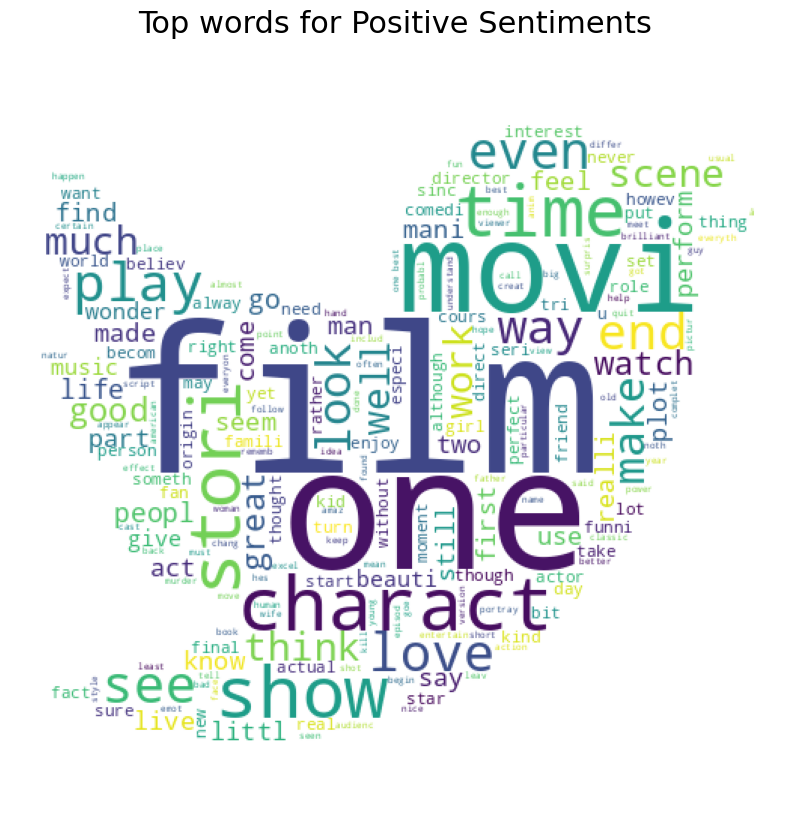

In [13]:
twitter_mask = np.array(Image.open('/kaggle/input/twittermask/twitter_mask3.jpg'))
wc = WordCloud(background_color='white',max_words=200,mask = twitter_mask,)
wc.generate(' '.join(text for text in df.loc[df['label']== 1,'text_clean']))
plt.figure(figsize =(18,10))
plt.title('Top words for Positive Sentiments',fontdict={'size':22,'verticalalignment':'bottom'})
plt.imshow(wc)
plt.axis('off')
plt.show()

In [14]:
corpus_negatives = create_corpus_df(df,0)
dic = defaultdict(int)
for word in corpus_negatives:
    dic[word]+=1
top = sorted(dic.items(),key=lambda x : x[1],reverse=True)[:10]
top

[('movi', 44725),
 ('film', 34416),
 ('one', 20561),
 ('like', 19154),
 ('make', 12325),
 ('get', 12123),
 ('even', 12112),
 ('bad', 12103),
 ('watch', 11666),
 ('good', 11580)]

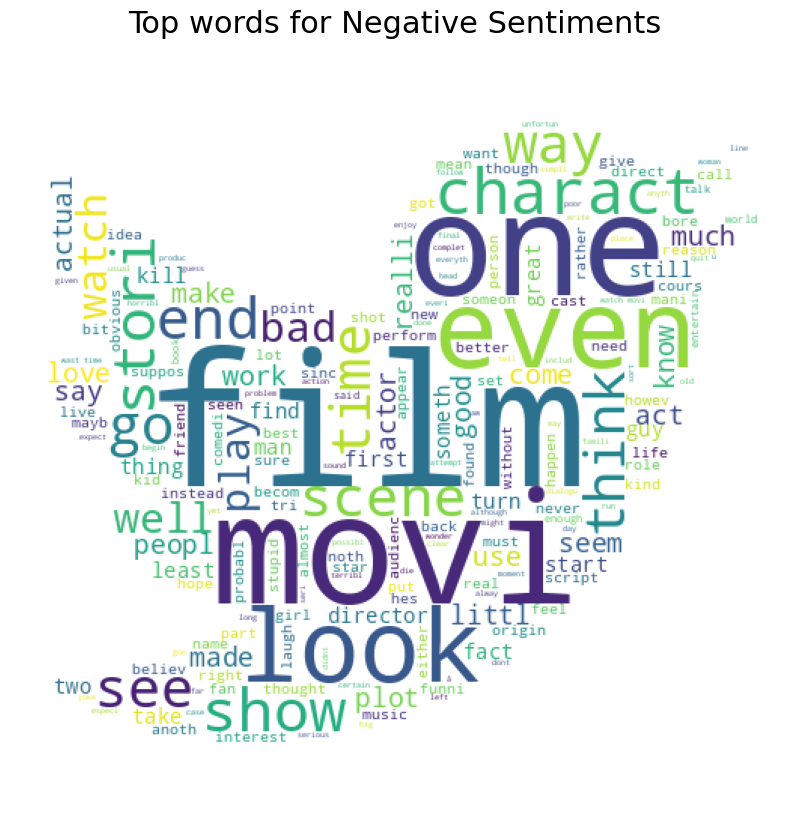

In [15]:
wc = WordCloud(background_color='white',max_words=200,mask = twitter_mask,)
wc.generate(' '.join(text for text in df.loc[df['label']== 0,'text_clean']))
plt.figure(figsize =(18,10))
plt.title('Top words for Negative Sentiments',fontdict={'size':22,'verticalalignment':'bottom'})
plt.imshow(wc)
plt.axis('off')
plt.show()

# Modelling

In [16]:
from sklearn.model_selection import train_test_split
x = df['text_clean']
y = df['label']
# split into train and test sets
x_train, x_test,y_train,y_test = train_test_split(x,y,random_state =42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

30000 30000
10000 10000


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
pipe = Pipeline([('bow',CountVectorizer()),
                  ('tfid',TfidfTransformer()),
                 ('model',XGBClassifier(
                     use_label_encoder = False,
                     eval_metric = 'auc',
                 ))
                ])

In [18]:
import plotly.figure_factory as ff
x_axes = ['Positive','Negative']
y_axes = ['Negative','Positive']
def conf_matrix(z,x=x_axes,y=y_axes):
    z=np.flip(z,0)
#   change each element of z to type annotation
    z_text = [[str(y) for y in x]for x in z]
#     set up figure
    fig = ff.create_annotated_heatmap(z,x=x,y=y,annotation_text=z_text,colorscale='viridis')
#     setup title
    fig.update_layout(title_text='<b>Confusion matrix </b>',
                     xaxis =dict(title='predicted value'),
                     yaxis = dict(title='Real value'))
#     add colorbar
    fig['data'][0]['showscale']=True
    return fig

In [19]:
from sklearn import metrics
# fit the pipeline with data
pipe.fit(x_train,y_train)
y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)
print('Train:{}'.format(metrics.accuracy_score(y_train,y_pred_train)))
print('Test:{}'.format(metrics.accuracy_score(y_test,y_pred_class)))
conf_matrix(metrics.confusion_matrix(y_test,y_pred_class))

Train:0.9416666666666667
Test:0.8476


# GloVe-LSTM

In [20]:
train_texts = df['text_clean'].values
train_label = df['label'].values
# calculate the length of the vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_texts)
vocab_length = len(word_tokenizer.word_index)+1
vocab_length

150740

In [21]:
def show_metrics(pred_tag,y_test):
    print('F1_Score:',f1_score(pred_tag,y_test))
    print('Precision:',precision_score(pred_tag,y_test))
    print('Recall:',recall_score(pred_tag,y_test))
    print('Accuracy',accuracy_score(pred_tag,y_test))
    print('_'*50)
    print(classification_report(pred_tag,y_test))
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

# pad sequence

In [25]:
longest_train = max(x,key=lambda sentence:len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
train_padded_sentences = pad_sequences(embed(x),length_long_sentence,padding='post')
train_padded_sentences

array([[1855,  890,   11, ...,    0,    0,    0],
       [ 139,    1,  214, ...,    0,    0,    0],
       [  24,   37,  309, ...,    0,    0,    0],
       ...,
       [ 269,   11,    1, ...,    0,    0,    0],
       [  30,   11, 6854, ...,    0,    0,    0],
       [  14,    2,    6, ...,    0,    0,    0]], dtype=int32)

GloVe

Load GloVe 100 embeddings

In [35]:
embeddings_dictionary = dict()
embeddings_dim = 100
#Load GloVe 100D embeddings
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:],dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

In [37]:
embedding_matrix = np.zeros((vocab_length,embeddings_dim))
for word,index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19915999, -0.049702  ,  0.24579   , ..., -0.068109  ,
         0.017651  ,  0.06455   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Modelling

In [39]:
#splitting data into training and testing sets
x_train,x_test,y_train,y_test = train_test_split(train_padded_sentences,y,test_size=0.25)
#load the model & train
def glove_ltsm():
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = length_long_sentence
    ))
    model.add(Bidirectional(LSTM(length_long_sentence,
                                return_sequences=True,recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence,activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [40]:
model = glove_ltsm()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    15,074,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,074,000 (57.50 MB)

 Trainable params: 15,074,000 (57.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#load the model and train
model = glove_ltsm()
checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    verbose=1,
    patience=5,
    min_lr=0.001
)
history = model.fit(x_train,y_train,epochs=7,batch_size=32,
                    validation_data=(x_test,y_test),verbose=1,callbacks=[reduce_lr,checkpoint])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Epoch 1/7
 10/938 ━━━━━━━━━━━━━━━━━━━━ 20:52:21 81s/step - accuracy: 0.5460 - loss: 3.0670

In [ ]:
# lets compare val and accuracy graphs
def plot_learning_curves(history,arr):
    fig,ax = plt.subplots(1,2,fig_size=(20,5))
    for idx in range(2):
        ax[idx].plot(history,history[arr[idx][0]])
        ax[idx].plot(history,history[arr[idx][1]])
        ax[idx].legend([arr[idx][0],arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel['A',fontsize=16]
        ax[idx].set_ylabel['B',fontsize=16]
        ax[idx].set_title(arr[idx][0]+'X'+arr[idx][1],fontsize=16)

In [ ]:
plt_learning_curves(history,[['loss','va']])